In [110]:
# !pip install medmnist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import collections
import medmnist
from medmnist import INFO, Evaluator
import itertools
import pandas as pd
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [3]:
# Define the dataset name and download flag
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 128

# Retrieve dataset information
info = INFO[data_flag]
task = info['task']  # Type of task (classification, segmentation, etc.)
n_channels = info['n_channels']  # Number of image channels (e.g., grayscale or RGB)
n_classes = len(info['label'])  # Number of classes

# Get the dataset class
DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [4]:
# Define a basic preprocessing transformation
data_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),
])

# Load training and test datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Load dataset in PIL format (for visualization purposes)
pil_dataset = DataClass(split='train', download=download)

# Encapsulate the datasets into DataLoader objects for batch processing
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\marta\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapo

In [116]:
# visualization

train_dataset.montage(length=1)

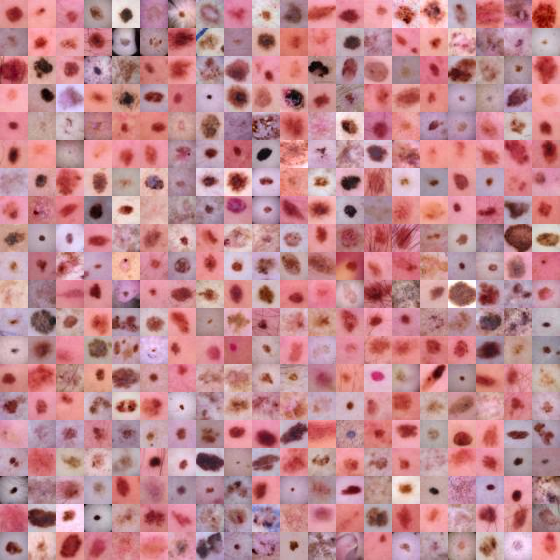

In [117]:
# montage

train_dataset.montage(length=20)

### Class Distribution Analysis

In this section, we analyzed the class distribution in the DermaMNIST dataset. First, we set the random seeds to ensure reproducibility of results across runs. Then, we retrieved the class labels from the dataset and printed them out. After that, we defined a function to count the number of samples per class in the given dataset (train, validation, or test).

We used this function to compute the class distribution for the training, validation, and test datasets. Finally, we visualized the class distribution using a bar plot. The bar plot displays the number of images per class for each dataset split (Training, Validation, and Test), which allows us to easily compare the distribution of samples across these splits.

Class Labels:
	0: actinic keratoses and intraepithelial carcinoma
	1: basal cell carcinoma
	2: benign keratosis-like lesions
	3: dermatofibroma
	4: melanoma
	5: melanocytic nevi
	6: vascular lesions


Class Distribution in the Dataset:
Training: Counter({5: 4693, 4: 779, 2: 769, 1: 359, 0: 228, 6: 99, 3: 80})
Validation: Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})
Test: Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})


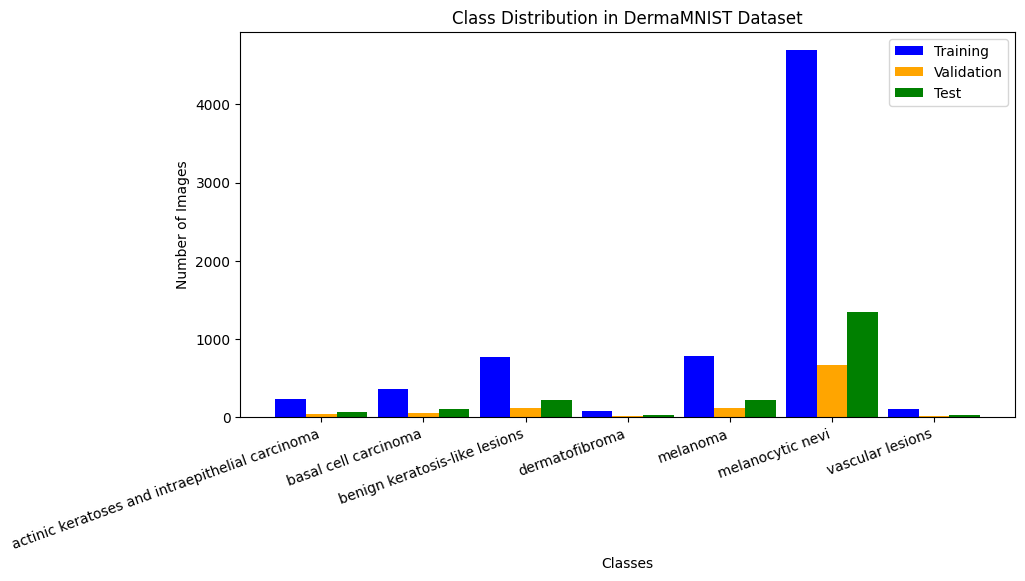

In [5]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Retrieve class labels
class_labels = info['label']  # Dictionary mapping class indices to class names
print(f"Class Labels:")
for i, label in enumerate(class_labels.values()):
    print(f"\t{i}: {label}")
print('\n')

# Function to count the number of samples per class
def count_classes(dataset):
    labels = []
    for i in range(len(dataset)):
        label = dataset[i][1]  # Extract label from dataset at index i
        label = label.item()  # Convert from tensor to a standard Python integer
        labels.append(label)  # Add the processed label to the list

    return collections.Counter(labels)

# Count class distribution in train, validation and test sets
train_counts = count_classes(train_dataset)
val_counts = count_classes(val_dataset)
test_counts = count_classes(test_dataset)

# Print class distribution
print("Class Distribution in the Dataset:")
print(f"Training: {train_counts}")
print(f"Validation: {val_counts}")
print(f"Test: {test_counts}")

# Convert counts into lists for plotting
labels = list(class_labels.values())
train_values = [train_counts[i] for i in range(len(labels))]
val_values = [val_counts[i] for i in range(len(labels))]
test_values = [test_counts[i] for i in range(len(labels))]

# Create a bar plot to visualize class distribution
fig, ax = plt.subplots(figsize=(10, 5))
width = 0.3  # Width of the bars

ax.bar([x - width for x in range(len(labels))], train_values, width=width, label='Training', color='blue')
ax.bar(range(len(labels)), val_values, width=width, label='Validation', color='orange')
ax.bar([x + width for x in range(len(labels))], test_values, width=width, label='Test', color='green')

ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
ax.set_title("Class Distribution in DermaMNIST Dataset")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.legend()

plt.show()

### Balancing the Dataset with Data Augmentation

In this section, we balanced the dataset by reducing the number of samples for overrepresented classes and augmenting the underrepresented classes using data augmentation techniques. 

First, we defined a series of transformations for data augmentation, including random rotations, horizontal flips, affine transformations, color jittering, and Gaussian blur. These transformations were applied to the underrepresented classes to generate new images and increase their sample size.

Then, we defined two functions:
- **`reduce_dataset`**: This function selects a limited number of samples from an overrepresented class to avoid class imbalance.
- **`balance_dataset`**: This function applies the defined transformations to generate additional samples for underrepresented classes.

The process is as follows:
1. **Reduce overrepresented classes**: We keep only a specific number of samples from the overrepresented classes to ensure no class has more than the desired number of samples.
2. **Apply data augmentation**: For classes with fewer samples than the target number, we generate new images using the augmentation techniques.
3. **Create a balanced training dataset**: Finally, we combine the reduced samples and the augmented data to form a balanced training dataset.
4. **Visualize the updated class distribution**: We print the new class distribution and visualize it using a bar plot.

This approach ensures that the training dataset is balanced across classes while keeping the validation and test sets unchanged.

New Class Distribution in the Dataset:
Training: Counter({0: 1000, 5: 1000, 4: 1000, 2: 1000, 1: 1000, 6: 1000, 3: 1000})
Validation: Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})
Test: Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})


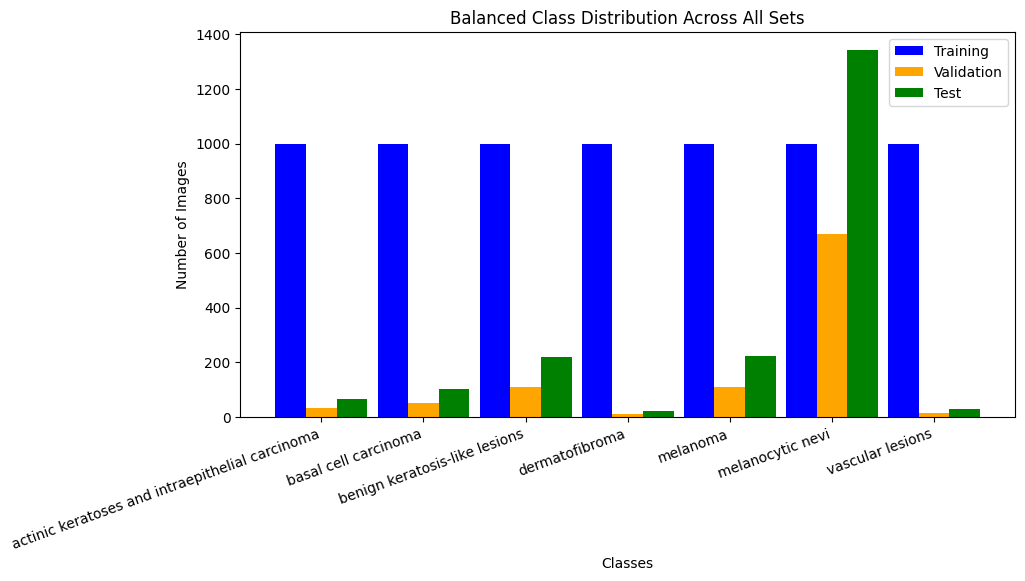

In [6]:
# Define transformations for Data Augmentation
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),  # Rotate image randomly by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip image horizontally with 50% probability
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation by 10%
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply Gaussian blur
])

# Function to filter dataset and keep only a limited number of samples from a specific class
def reduce_dataset(dataset, target_class, num_keep):
    """Keeps only 'num_keep' examples of 'target_class'"""
    indices = [i for i in range(len(dataset)) if dataset[i][1].item() == target_class]
    selected_indices = random.sample(indices, num_keep)
    return [dataset[i] for i in selected_indices]

# Function to augment dataset for underrepresented classes
def balance_dataset(dataset, target_class, num_augment):
    """Generates 'num_augment' new images for 'target_class' using data augmentation"""
    indices = [i for i in range(len(dataset)) if dataset[i][1].item() == target_class]
    
    augmented_data = []
    for _ in range(num_augment):
        original_index = random.choice(indices)
        image, label = dataset[original_index]
        augmented_image = augmentation_transforms(image)
        augmented_data.append((augmented_image, label))
    
    return augmented_data

# Desired number of samples per class
TARGET_SAMPLES = 1000

# Step 1: Reduce classes with more than TARGET_SAMPLES
reduced_train_data = []

for cls in train_counts:
    num_samples = train_counts[cls]
    if num_samples > TARGET_SAMPLES:
        reduced_train_data += reduce_dataset(train_dataset, cls, TARGET_SAMPLES)
    else:
        reduced_train_data += [sample for sample in train_dataset if sample[1].item() == cls]

# Step 2: Apply Data Augmentation to underrepresented classes
augmented_data = []
train_counts_reduced = count_classes(reduced_train_data)

for cls in train_counts_reduced:
    current_count = train_counts_reduced[cls]
    if current_count < TARGET_SAMPLES:
        needed = TARGET_SAMPLES - current_count
        augmented_data += balance_dataset(reduced_train_data, cls, needed)

# Step 3: Create final balanced dataset
train_dataset_balanced = reduced_train_data + augmented_data
train_balanced_loader = DataLoader(train_dataset_balanced, batch_size=BATCH_SIZE, shuffle=True)

# Step 4: Verify new class distribution
train_counts_new = count_classes(train_dataset_balanced)

# Print updated class distribution
print("New Class Distribution in the Dataset:")
print(f"Training: {train_counts_new}")
print(f"Validation: {val_counts}")  # Validation remains the same
print(f"Test: {test_counts}")  # Test remains the same

# Plot the balanced class distribution
train_values_new = [train_counts_new[i] for i in range(len(labels))]
val_values_new = [val_counts[i] for i in range(len(labels))]
test_values_new = [test_counts[i] for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(10, 5))
width = 0.3
ax.bar([x - width for x in range(len(labels))], train_values_new, width=width, color='blue', label='Training')
ax.bar(range(len(labels)), val_values_new, width=width, color='orange', label='Validation')
ax.bar([x + width for x in range(len(labels))], test_values_new, width=width, color='green', label='Test')

ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
ax.set_title("Balanced Class Distribution Across All Sets")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=20, ha="right")
ax.legend()

plt.show()

### Defining and Tuning the MLP Model

In this section, we defined a multi-layer perceptron (MLP) model for training. The architecture consists of several fully connected layers, followed by ReLU activation functions and dropout layers for regularization. The model's input size is set to match the flattened dimensions of the RGB images (3 channels × 28 × 28 pixels). The hidden layers can be customized via the `hidden_sizes` parameter, while the output layer produces predictions for the number of classes.

Key components of the model:
- **MLP Class**: The class defines a sequential neural network using the PyTorch `nn.Module`. It includes:
  - Hidden layers with ReLU activations and dropout for regularization.
  - A final output layer for classification.
  - Weight initialization using Xavier uniform distribution (it's appropriate for ReLU activation).
  
- **Device Setup**: The model is set to use the GPU if available, otherwise, it defaults to the CPU.

- **Hyperparameter Grid Search**: To tune the model, a grid search is performed over different hyperparameters:
  - `hidden_sizes`: Varying the number of neurons in the hidden layers.
  - `learning_rate`: Different learning rates for the optimizer.
  - `batch_size`: Testing different batch sizes for the DataLoader.
  - `dropout`: Various dropout rates to prevent overfitting.

  In addition, a set of loss functions and optimizers is defined to be tested during the grid search:
  - **Loss Functions**: Cross-entropy loss and multi-margin loss.
  - **Optimizers**: Adam and RMSprop.

Finally, we generated all combinations of the hyperparameters and loss/optimizer settings, preparing them for the grid search.

This setup allows us to experiment with different model architectures, learning rates, and regularization techniques to find the optimal configuration for training.

In [8]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=3*28*28, hidden_sizes=[512, 256, 128], output_size=n_classes, dropout_p=0.1):
        super(MLP, self).__init__()

        layers = []  # List to store layers sequentially
        prev_size = input_size  # Keep track of input size for each layer

        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))  # Fully connected layer
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.Dropout(dropout_p))  # Dropout for regularization
            prev_size = hidden_size  # Update previous layer size

        # Add output layer
        layers.append(nn.Linear(prev_size, output_size))

        self.model = nn.Sequential(*layers)  # Create a sequential model from layers
    
    def forward(self, x):
        # Flatten the input images into 1D vectors before passing through the network
        x = x.view(x.size(0), -1)  # Reshape (batch_size, 3, 28, 28) -> (batch_size, 3*28*28)
        return self.model(x)  # Forward pass through the network
    
    @staticmethod
    def init_weights(m):
        # Initialize weights of the model
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization for weights -> good for ReLU activations
            nn.init.zeros_(m.bias)  # Initialize biases to zero

# Set up device (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Different parameters for the model -----
param_grid = {
    'hidden_sizes': [[512, 256, 128], [256, 128, 64], [512, 256, 128, 64], [512, 512, 256], [64, 64, 64, 64, 64]],  # Sizes of hidden layers
    'learning_rate': [0.001, 0.0001, 0.0005],  # Learning rates for optimizers
    'batch_size': [64, 128, 256],  # Batch sizes for DataLoader
    'dropout': [0.05, 0.1]  # Dropout rates for regularization
}

loss_and_opt = {
    'loss_function': [nn.CrossEntropyLoss, nn.MultiMarginLoss],  # Loss functions to be used
    'optimizer': [optim.Adam, optim.RMSprop],  # Optimizers to be used
}

# Generate all possible combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Generate all possible combinations of loss functions and optimizers
all_loss_and_opt = [dict(zip(loss_and_opt.keys(), v)) for v in itertools.product(*loss_and_opt.values())]
#-----------------------------------------------

Using device: cpu


### Training for Visualization of Optimal Epochs on the Unbalanced Dataset

In this section, we defined the training process to visualize how the model's loss and accuracy evolve over different epochs. The primary goal here was to visualize the point at which the model's performance stabilizes in order to choose the optimal number of epochs for training on the unbalanced dataset.

Key Points:
1. **Static Parameter Values**:
   - The hyperparameters (such as the model architecture, learning rate, dropout rate, and batch size) were pre-determined and remain fixed throughout this training run.
   - The choice of **loss function** (`CrossEntropyLoss`), **optimizer** (Adam), and **learning rate** (0.001) are not subject to change in this case. They were selected beforehand and are being used as static values just to observe the training behavior.
   - Similarly, the **number of epochs** (150) is fixed to allow the visualization of how the model behaves over a set range of epochs.

2. **Training for Visualization**:
   - The training loop was set up to run with these static parameters, and the focus is on tracking how the model's loss and accuracy change across epochs.
   - Since the parameters are not being tuned dynamically, this process is purely for visualizing the **optimal number of epochs** required to reach stable performance, particularly with the unbalanced dataset.
   - The model is not expected to reach the best possible performance during this process; instead, we just wanted to observe when the model's performance (loss and accuracy) started to stabilize, which informs us about when to stop training the actual model in future runs.

3. **Choosing the Optimal Number of Epochs for the Unbalanced Dataset**:
   - By observing the plots of loss and accuracy over the course of the 150 epochs, we can visually identify the point where the model's loss no longer significantly decreases, and the accuracy starts to stabilize.
   - Based on these visualizations, we determined that **130 epochs** is the optimal number of epochs where the model’s performance stabilizes, and further training no longer leads to significant improvements.
   - This information is crucial for the future training runs, particularly when dealing with the **unbalanced dataset**, where training might be more sensitive to how long we let the model train.
   - The purpose of this training run is purely exploratory, as we do not expect significant improvements in model performance due to the fixed parameters. Instead, it serves as a means to determine the best stopping point for training the actual model.
   - The optimal number of epochs determined from this process is used for training the model on the unbalanced dataset, ensuring that the model does not overtrain and potentially overfit to the majority class.

Epoch 1, Loss: 1.0640, Accuracy: 0.6525
Epoch 2, Loss: 0.9487, Accuracy: 0.6738
Epoch 3, Loss: 0.9107, Accuracy: 0.6806
Epoch 4, Loss: 0.8852, Accuracy: 0.6902
Epoch 5, Loss: 0.8644, Accuracy: 0.6989
Epoch 6, Loss: 0.8477, Accuracy: 0.7024
Epoch 7, Loss: 0.8178, Accuracy: 0.7032
Epoch 8, Loss: 0.7894, Accuracy: 0.7101
Epoch 9, Loss: 0.7732, Accuracy: 0.7218
Epoch 10, Loss: 0.7543, Accuracy: 0.7288
Epoch 11, Loss: 0.7452, Accuracy: 0.7297
Epoch 12, Loss: 0.7277, Accuracy: 0.7381
Epoch 13, Loss: 0.7111, Accuracy: 0.7443
Epoch 14, Loss: 0.6872, Accuracy: 0.7541
Epoch 15, Loss: 0.6759, Accuracy: 0.7528
Epoch 16, Loss: 0.6857, Accuracy: 0.7567
Epoch 17, Loss: 0.6551, Accuracy: 0.7644
Epoch 18, Loss: 0.6484, Accuracy: 0.7635
Epoch 19, Loss: 0.6247, Accuracy: 0.7695
Epoch 20, Loss: 0.6192, Accuracy: 0.7735
Epoch 21, Loss: 0.5723, Accuracy: 0.7865
Epoch 22, Loss: 0.5385, Accuracy: 0.8018
Epoch 23, Loss: 0.5358, Accuracy: 0.8080
Epoch 24, Loss: 0.5217, Accuracy: 0.8106
Epoch 25, Loss: 0.5059, A

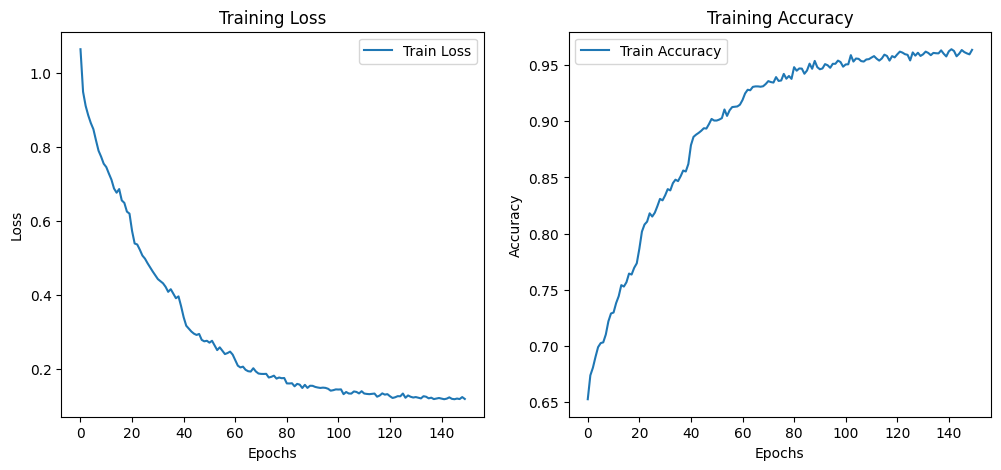

In [121]:
# Create a new model instance with the current parameters
model_MLP = MLP().to(device)

model_MLP.apply(MLP.init_weights)  # Initialize weights

criterion = nn.CrossEntropyLoss()  # Create loss function instance
optimizer = optim.Adam(model_MLP.parameters(), lr=0.001, weight_decay = 1e-4)  # Create optimizer instance
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Learning rate scheduler

# Store the history of loss and accuracy
history = {
    'train_loss': [],
    'train_acc': [],
}

# Training loop
num_epochs = 150  # Number of epochs for training
for epoch in range(num_epochs):
    model_MLP.train()  # Set the model to training mode
    running_loss = 0.0  # Accumulator for loss values
    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total predictions

    # Iterate through mini-batches of the training dataset
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)  # Ensure labels are class indices

        optimizer.zero_grad()  # Reset gradients before backpropagation
        outputs = model_MLP(images)  # Forward pass: compute predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update weights using the optimizer

        running_loss += loss.item()  # Accumulate loss for reporting
        _, predicted = torch.max(outputs.data, 1)  # Get class index with highest probability
        total += labels.size(0)  # Update total sample count
        correct += (predicted == labels).sum().item()  # Count correct predictions

    scheduler.step()  # Update learning rate using the scheduler

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
    epoch_acc = correct / total  # Accuracy for the epoch

    history['train_loss'].append(epoch_loss)  # Store loss in history
    history['train_acc'].append(epoch_acc)  # Store accuracy in history

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Validation (evaluation on the validation dataset)
y_true, y_pred = [], []  # Lists to store true and predicted labels
model_MLP.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)  # Convert labels to class indices

        outputs = model_MLP(images)  # Get model predictions
        predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

        y_true.extend(labels.cpu().numpy())  # Store true labels
        y_pred.extend(predictions.cpu().numpy())  # Store predicted labels


# Plot the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Training and Validation on the Unbalanced Dataset

In this section, we trained the model with multiple combinations of hyperparameters to identify the best-performing model on the unbalanced dataset. The goal was to find the optimal combination of parameters, including the hidden layer sizes, dropout rates, learning rates, and batch sizes, to maximize performance on the validation dataset.

#### Key Steps:
1. **Hyperparameter Search**:
   - We defined a grid search for hyperparameters (`hidden_sizes`, `learning_rate`, `batch_size`, and `dropout`), where we try all possible combinations.
   - The purpose of this was to evaluate how different parameter configurations affect model performance. This process was particularly valuable when working with an unbalanced dataset, as it allowed us to explore various settings that helped improve performance.

2. **Model Initialization**:
   - A new model instance (`MLP`) was created for each combination of hyperparameters.
   - The model was then initialized using Xavier uniform distribution for weights and zeros for biases to ensure a good starting point for training.

3. **Training Loop**:
   - For each parameter combination, the training loop runs for **130 epochs**, which was the optimal number of epochs determined previously.
   - During each epoch, the model was trained using the Adam optimizer, with a learning rate scheduler to adjust the learning rate after every 20 epochs.
   - After each mini-batch, the model's weights are updated using backpropagation, and the loss and accuracy are computed for monitoring progress.

4. **Validation and Metrics**:
   - After each training run, we evaluated the model on the validation set by generating predictions and computing the confusion matrix, classification report, and weighted average F1 score.
   - The **weighted F1 score** was chosen as the primary metric to evaluate model performance due to the class imbalance. This score considers both precision and recall, making it more informative than accuracy alone.

5. **Model Selection**:
   - After evaluating all combinations, we compared the weighted F1 scores. The model that achieves the highest weighted F1 score is considered the best model.
   - The best model, along with its parameters and the associated metrics, were saved to a file (`best_mlp_model_params.pth`).

6. **Saving Results**:
   - The results of the grid search (including parameter combinations, training loss, training accuracy, and weighted F1 scores) are saved into a CSV file (`mlp_grid_search_results.csv`) for further analysis.

In [122]:
# To save the best model and its parameters
best_weighted_f1 = 0
best_model = None
best_params = None
results = []

print(f"Total combinations to try: {len(all_params)}")

for i, params in enumerate(all_params):
    print(f"\nTraining combination {i+1}/{len(all_params)}")
    print("Parameters:", params)

    # Create DataLoader with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create a new model instance with the current parameters
    model_MLP = MLP(hidden_sizes=params['hidden_sizes'], dropout_p=params['dropout']).to(device)

    model_MLP.apply(MLP.init_weights)  # Initialize weights

    criterion = nn.CrossEntropyLoss()  # Create loss function instance
    optimizer = optim.Adam(model_MLP.parameters(), lr=params['learning_rate'], weight_decay = 1e-4)  # Create optimizer instance
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Learning rate scheduler

    # Store the history of loss and accuracy
    history = {
        'train_loss': [],
        'train_acc': [],
    }

    # Training loop
    num_epochs = 130  # Number of epochs for training
    for epoch in range(num_epochs):
        model_MLP.train()  # Set the model to training mode
        running_loss = 0.0  # Accumulator for loss values
        correct = 0  # Counter for correct predictions
        total = 0  # Counter for total predictions

        # Iterate through mini-batches of the training dataset
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)  # Ensure labels are class indices

            optimizer.zero_grad()  # Reset gradients before backpropagation
            outputs = model_MLP(images)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update weights using the optimizer

            running_loss += loss.item()  # Accumulate loss for reporting
            _, predicted = torch.max(outputs.data, 1)  # Get class index with highest probability
            total += labels.size(0)  # Update total sample count
            correct += (predicted == labels).sum().item()  # Count correct predictions

        scheduler.step()  # Update learning rate using the scheduler

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)  # Average loss for the epoch
        epoch_acc = correct / total  # Accuracy for the epoch

        history['train_loss'].append(epoch_loss)  # Store loss in history
        history['train_acc'].append(epoch_acc)  # Store accuracy in history

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation (evaluation on the validation dataset)
    y_true, y_pred = [], []  # Lists to store true and predicted labels
    model_MLP.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)  # Convert labels to class indices

            outputs = model_MLP(images)  # Get model predictions
            predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

            y_true.extend(labels.cpu().numpy())  # Store true labels
            y_pred.extend(predictions.cpu().numpy())  # Store predicted labels

    conf_matrix = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    class_report = classification_report(y_true, y_pred, target_names=class_labels.values())  # Generate classification report
    class_report_dict = classification_report(y_true, y_pred, target_names=class_labels.values(), output_dict=True)
    f1_weighted_avg = class_report_dict['weighted avg']['f1-score']  # Extract weighted F1 score
    print(f"Validation Weighted AVG F1 Score: {f1_weighted_avg:.2%}")

    # Save results
    results.append({
        'params': params,
        'f1_weighted_avg': f1_weighted_avg,
        'train_loss': history['train_loss'],
        'train_acc': history['train_acc'],
    })

    # Check if this model is the best one so far
    if f1_weighted_avg > best_weighted_f1:
        best_weighted_f1 = f1_weighted_avg # Update best F1 score
        best_model = model_MLP  # Save the best model
        best_params = params  # Save the best parameters
        print("New best model found!")

        # Save the best model
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'params': best_params,
            'f1_weighted_avg': best_weighted_f1,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'train_loss': history['train_loss'],
            'train_acc': history['train_acc'],
        }, 'best_mlp_model_params.pth')


# Print the best model and its parameters
print("\nBest Model Parameters:")
print(f"Parameters: {best_params}")
print(f"Best Validation F1 Score: {best_weighted_f1:.2%}")

# Save all results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv('mlp_grid_search_results.csv', index=False)

Total combinations to try: 90

Training combination 1/90
Parameters: {'hidden_sizes': [512, 256, 128], 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.05}
Epoch 1, Loss: 1.0191, Accuracy: 0.6596
Epoch 2, Loss: 0.9338, Accuracy: 0.6768
Epoch 3, Loss: 0.8865, Accuracy: 0.6859
Epoch 4, Loss: 0.8574, Accuracy: 0.6927
Epoch 5, Loss: 0.8281, Accuracy: 0.7000
Epoch 6, Loss: 0.8148, Accuracy: 0.7047
Epoch 7, Loss: 0.7734, Accuracy: 0.7180
Epoch 8, Loss: 0.7712, Accuracy: 0.7187
Epoch 9, Loss: 0.7341, Accuracy: 0.7336
Epoch 10, Loss: 0.7262, Accuracy: 0.7370
Epoch 11, Loss: 0.7071, Accuracy: 0.7433
Epoch 12, Loss: 0.6808, Accuracy: 0.7505
Epoch 13, Loss: 0.6825, Accuracy: 0.7520
Epoch 14, Loss: 0.6596, Accuracy: 0.7611
Epoch 15, Loss: 0.6376, Accuracy: 0.7665
Epoch 16, Loss: 0.6343, Accuracy: 0.7712
Epoch 17, Loss: 0.6145, Accuracy: 0.7822
Epoch 18, Loss: 0.5977, Accuracy: 0.7846
Epoch 19, Loss: 0.6040, Accuracy: 0.7818
Epoch 20, Loss: 0.5814, Accuracy: 0.7886
Epoch 21, Loss: 0.5084, Acc

### Training and Validation with Best Model Configuration and Hyperparameters

In this section, we took the best model from the previous grid search and further refined it by testing different combinations of loss functions and optimizers. The purpose was to assess whether alternative choices of loss functions and optimizers can improve the model's performance on the validation set, using the previously found optimal parameters for the model.

#### Key Steps:

1. **Loading the Best Model**:
   - The best model from the previous training (which includes the optimal hyperparameters) was loaded from a saved checkpoint file (`best_mlp_model_params.pth`).
   - This checkpoint includes the model’s parameters (`hidden_sizes`, `learning_rate`, `batch_size`, `dropout`), along with its state_dict (weights), loss history, accuracy, and F1 score.

2. **Plotting Training History**:
   - We visualize the training loss and accuracy over the 130 epochs to examine how the model performed during the initial training. These plots help to analyze whether the model has converged and provide insight into the training dynamics.

3. **Evaluating Different Loss Functions and Optimizers**:
   - A list of different **loss functions** and **optimizers** (`all_loss_and_opt`) is iterated over, with each combination being tested on the best model configuration.
   - For each combination, a new model is created, initialized with the best `hidden_sizes` and `dropout` parameters. The corresponding loss function and optimizer are used to train the model.

4. **Training Loop**:
   - The model is trained for **130 epochs** using the selected loss function and optimizer for each iteration.
   - Similar to the earlier training, we track and compute loss and accuracy for every epoch.

5. **Validation**:
   - After each training session, the model is evaluated on the validation dataset to compute:
     - **Confusion Matrix**: For assessing the model’s performance across all classes.
     - **Classification Report**: For detailed metrics like precision, recall, and F1 score.
     - **Weighted Average F1 Score**: This score is used as the primary metric due to the unbalanced nature of the dataset.
   
6. **Model Selection**:
   - If a model achieves a higher weighted average F1 score than the current best model, it is saved as the best model.
   - The corresponding **loss function** and **optimizer** settings are also saved to `best_mlp_model_l_o.pth`.
   
7. **Final Evaluation**:
   - If no better model is found after testing all combinations of loss functions and optimizers, the best-performing model from the previous grid search is saved again.
   
8. **Saving Results**:
   - The results of each iteration, including F1 scores, training loss, and accuracy, are stored in `mlp_l_and_o_results.csv` for further analysis.

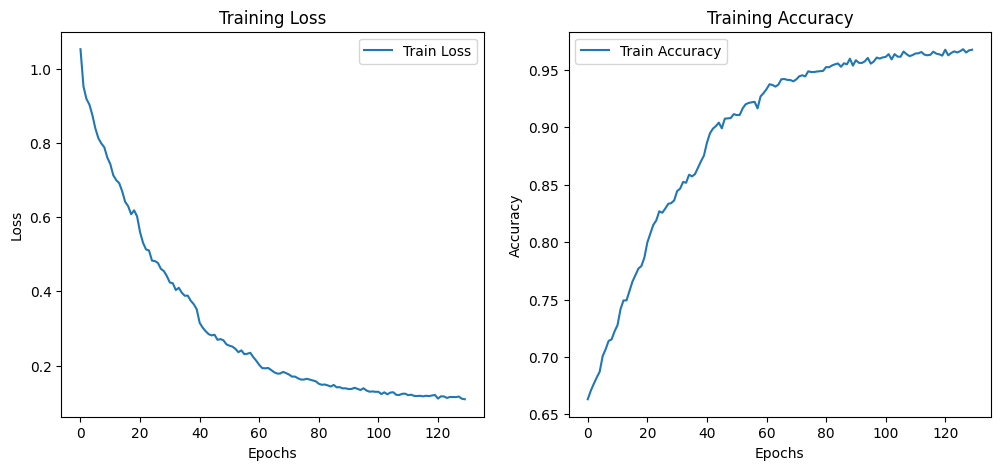


Training combination 1/4
Parameters: {'loss_function': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1, Loss: 1.1713, Accuracy: 0.6191
Epoch 2, Loss: 0.9837, Accuracy: 0.6643
Epoch 3, Loss: 0.9425, Accuracy: 0.6723
Epoch 4, Loss: 0.9127, Accuracy: 0.6802
Epoch 5, Loss: 0.8921, Accuracy: 0.6823
Epoch 6, Loss: 0.8630, Accuracy: 0.6950
Epoch 7, Loss: 0.8360, Accuracy: 0.7007
Epoch 8, Loss: 0.8116, Accuracy: 0.7081
Epoch 9, Loss: 0.7898, Accuracy: 0.7186
Epoch 10, Loss: 0.7741, Accuracy: 0.7179
Epoch 11, Loss: 0.7373, Accuracy: 0.7336
Epoch 12, Loss: 0.7215, Accuracy: 0.7403
Epoch 13, Loss: 0.7069, Accuracy: 0.7431
Epoch 14, Loss: 0.6837, Accuracy: 0.7574
Epoch 15, Loss: 0.6774, Accuracy: 0.7570
Epoch 16, Loss: 0.6685, Accuracy: 0.7591
Epoch 17, Loss: 0.6547, Accuracy: 0.7685
Epoch 18, Loss: 0.6352, Accuracy: 0.7765
Epoch 19, Loss: 0.6188, Accuracy: 0.7789
Epoch 20, Loss: 0.6064, Accuracy: 0.7832
Epoch 21, Loss: 0.5865, Accuracy: 0.7

In [24]:
# Load the best model
checkpoint = torch.load('best_mlp_model_params.pth', weights_only=False)
best_hidden_sizes = checkpoint['params']['hidden_sizes']
best_learning_rate = checkpoint['params']['learning_rate']
best_batch_size = checkpoint['params']['batch_size']
best_dropout = checkpoint['params']['dropout']
best_weighted_f1 = checkpoint['f1_weighted_avg']
best_params = checkpoint['params']
best_model = checkpoint['model_state_dict']

# Plot the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(checkpoint['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(checkpoint['train_acc'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the best_l_and_o with the static loss function and optimizer that were used to be trained
best_l_and_o = {
    'loss_function': nn.CrossEntropyLoss,
    'optimizer': optim.Adam,
}
results_l_o = []  # List to store results for different loss functions and optimizers

# Create DataLoader with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

for i, l_o in enumerate(all_loss_and_opt):
    print(f"\nTraining combination {i+1}/{len(all_loss_and_opt)}")
    print("Parameters:", l_o)

    # Create a new model instance with the current parameters
    best_MLP = MLP(hidden_sizes=best_hidden_sizes, dropout_p=best_dropout).to(device)
    best_MLP.apply(MLP.init_weights)  # Initialize weights

    criterion = l_o['loss_function']()  # Create loss function instance
    optimizer = l_o['optimizer'](best_MLP.parameters(), lr=best_learning_rate, weight_decay = 1e-4)  # Create optimizer instance
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduler

    # Store the history of loss and accuracy
    history = {
        'train_loss': [],
        'train_acc': [],
    }

    # Training loop
    for epoch in range(130):
        best_MLP.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = best_MLP(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation (evaluation on the validation dataset)
    y_val_true, y_val_pred = [], []  # Lists to store true and predicted labels
    best_MLP.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = best_MLP(images)  # Get model predictions
            predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

            y_val_true.extend(labels.cpu().numpy())  # Store true labels
            y_val_pred.extend(predictions.cpu().numpy())

    conf_matrix = confusion_matrix(y_val_true, y_val_pred)  # Compute confusion matrix
    class_report = classification_report(y_val_true, y_val_pred, target_names=class_labels.values())  # Generate classification report
    class_report_dict = classification_report(y_val_true, y_val_pred, target_names=class_labels.values(), output_dict=True)
    f1_weighted_avg = class_report_dict['weighted avg']['f1-score']  # Extract weighted F1 score
    print(f"Validation Weighted AVG F1 Score: {f1_weighted_avg:.2%}")

    # Save results
    results_l_o.append({
        'params': l_o,
        'f1_weighted_avg': f1_weighted_avg,
        'train_loss': history['train_loss'],
        'train_acc': history['train_acc'],
    })

    flag = False
    if f1_weighted_avg > best_weighted_f1:
        flag = True
        best_weighted_f1 = f1_weighted_avg
        best_model = best_MLP
        best_l_and_o = l_o  # Save the best loss function and optimizer
        print("New best model found!")

        # Save the best model
        torch.save({
            'model_state_dict': best_MLP.state_dict(),
            'params': best_params,
            'loss_and_opt': best_l_and_o,
            'f1_weighted_avg': best_weighted_f1,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'train_loss': history['train_loss'],
            'train_acc': history['train_acc'],
        }, 'best_mlp_model_l_o.pth')

    if not flag and i == len(all_loss_and_opt) - 1:  # Check if this is the last iteration
        print("No better model found with different loss function and optimizer.")

        torch.save({
            'model_state_dict': best_model,
            'params': best_params,
            'loss_and_opt': best_l_and_o,
            'f1_weighted_avg': best_weighted_f1,
            'confusion_matrix': checkpoint['confusion_matrix'],
            'classification_report': checkpoint['classification_report'],
            'train_loss': checkpoint['train_loss'],
            'train_acc': checkpoint['train_acc'],
        }, 'best_mlp_model_l_o.pth')

# Print the best model and its parameters
print("\nBest Model Parameters:")
print(f"Loss and Opt: {best_l_and_o}")
print(f"Best Validation Weighted AVG F1 Score: {best_weighted_f1:.2%}")

results_df_l_o = pd.DataFrame(results_l_o)
results_df_l_o.to_csv('mlp_l_and_o_results.csv', index=False)

### Evaluating the Best Model on the Test Dataset

In this step, we load the previously saved best model that was trained with the optimal parameters, loss function, and optimizer. The model is then evaluated on the test dataset to assess its performance and generate confusion matrices and classification reports.

#### Key Steps:

1. **Loading the Best Model**:
   - The best model is loaded from the checkpoint file `best_mlp_model_l_o.pth`, which contains the model state, parameters, confusion matrix, and classification report from the validation phase.
   - The confusion matrix and classification report for the validation set are printed and visualized.

2. **Plotting the Validation Confusion Matrix**:
   - A heatmap of the confusion matrix for the validation set is generated using `seaborn` to visualize how well the model performed across different classes. The x-axis represents predicted labels, and the y-axis represents true labels.

3. **Model Preparation for Testing**:
   - The model architecture is reconstructed using the saved `hidden_sizes` and `dropout_p` values, and the saved model weights are loaded into the model.
   - The model is set to evaluation mode using `model.eval()` to ensure that layers like dropout are disabled during inference.

4. **Testing on the Test Dataset**:
   - The model is evaluated on the test dataset, where predictions are made for each batch of test images.
   - The predicted labels are compared with the true labels, and both are stored for further evaluation.

5. **Confusion Matrix and Classification Report for Testing**:
   - A confusion matrix is computed for the test set to evaluate how well the model performs across all classes.
   - A classification report is generated for the test set, including key metrics such as precision, recall, and F1 score.
   - The weighted average F1 score is extracted from the classification report and printed.

6. **Plotting the Test Confusion Matrix**:
   - A heatmap of the confusion matrix for the test set is visualized to assess the model's classification performance across the classes.
   
7. **Final Performance Metrics**:
   - The test results, including the weighted average F1 score, confusion matrix, and classification report, are printed.

Validation Confusion Matrix:



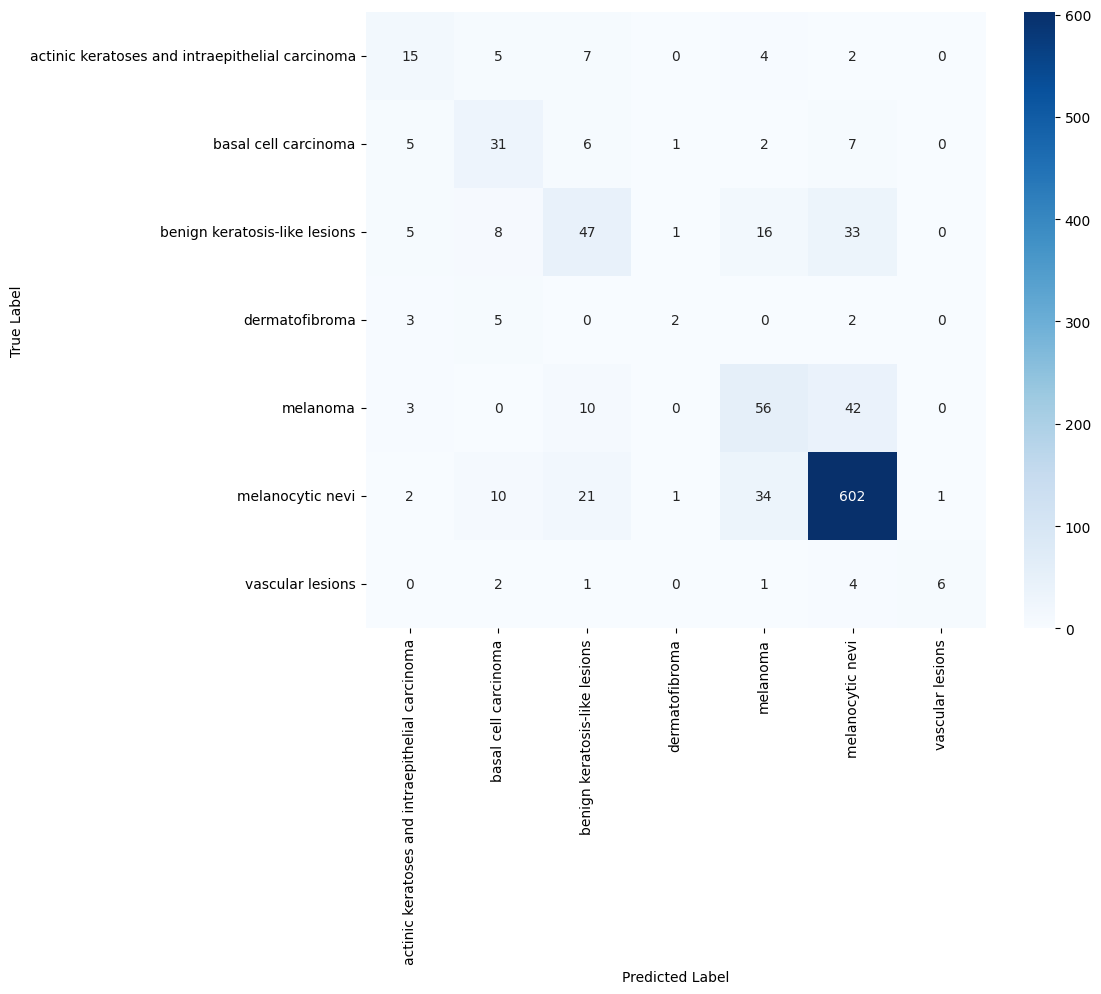


Validation Classification Report:
                                                  precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.45      0.45      0.45        33
                           basal cell carcinoma       0.51      0.60      0.55        52
                  benign keratosis-like lesions       0.51      0.43      0.47       110
                                 dermatofibroma       0.40      0.17      0.24        12
                                       melanoma       0.50      0.50      0.50       111
                               melanocytic nevi       0.87      0.90      0.88       671
                               vascular lesions       0.86      0.43      0.57        14

                                       accuracy                           0.76      1003
                                      macro avg       0.59      0.50      0.52      1003
                                   weighted avg       0.75      0.76    

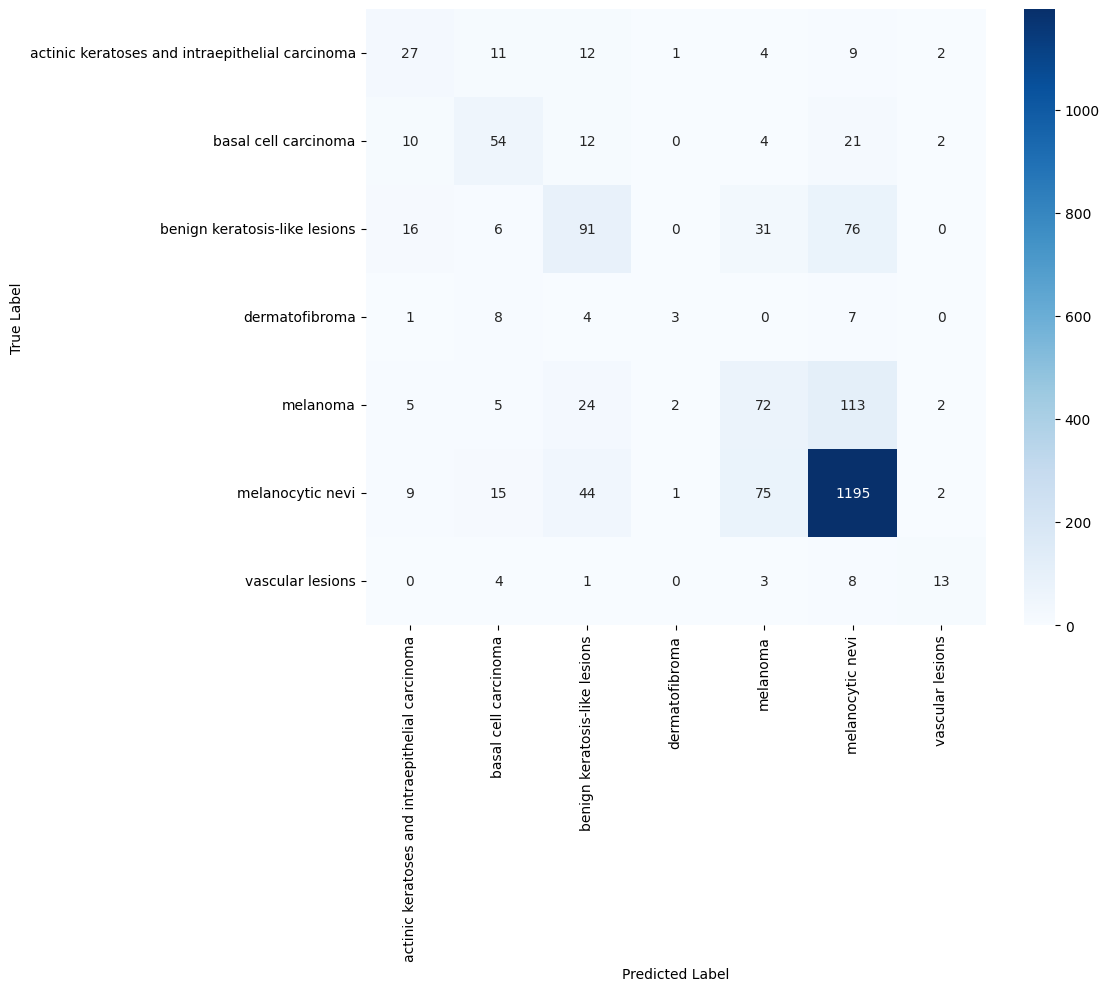


Test Classification Report:
                                                  precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.40      0.41      0.40        66
                           basal cell carcinoma       0.52      0.52      0.52       103
                  benign keratosis-like lesions       0.48      0.41      0.45       220
                                 dermatofibroma       0.43      0.13      0.20        23
                                       melanoma       0.38      0.32      0.35       223
                               melanocytic nevi       0.84      0.89      0.86      1341
                               vascular lesions       0.62      0.45      0.52        29

                                       accuracy                           0.73      2005
                                      macro avg       0.52      0.45      0.47      2005
                                   weighted avg       0.71      0.73      0.71

In [ ]:
# Load the best model
checkpoint = torch.load('best_mlp_model_l_o.pth', weights_only=False)
conf_matrix = checkpoint['confusion_matrix']
class_report = checkpoint['classification_report']

print("Validation Confusion Matrix:\n")
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nValidation Classification Report:\n", class_report)

best_model_MLP = MLP(hidden_sizes=checkpoint['params']['hidden_sizes'], 
                dropout_p=checkpoint['params']['dropout']).to(device)
best_model_MLP.load_state_dict(checkpoint['model_state_dict'])
best_model_MLP.eval()  # Set to evaluation mode


# Testing (evaluation on the test dataset)
y_test_pred = []  # List to store predicted labels
y_test_true = []  # List to store true labels

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # Move images to device
        labels = labels.squeeze().long().to(device)  # Convert labels to class indices
        
        outputs = best_model_MLP(images)  # Get model predictions
        predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability
        
        y_test_true.extend(labels.cpu().numpy())  # Store true labels
        y_test_pred.extend(predictions.cpu().numpy())  # Store predicted labels

conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)  # Compute confusion matrix
class_report_test = classification_report(y_test_true, y_test_pred, target_names=class_labels.values())  # Generate classification report
class_report_dict_test = classification_report(y_test_true, y_test_pred, target_names=class_labels.values(), output_dict=True)
f1_weighted_avg_test = class_report_dict_test['weighted avg']['f1-score']  # Extract weighted F1 score
print(f"Test Weighted AVG F1 Score: {f1_weighted_avg_test:.2%}")

print("Test Confusion Matrix:\n")  # Print confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nTest Classification Report:\n", class_report_test)  # Print classification report

### Training for Visualization of Optimal Epochs on the Balanced Dataset

In this section, we trained the model using the balanced dataset to determine the optimal number of epochs for training. The steps followed are similar to the unbalanced dataset, with a primary focus on monitoring the training loss and accuracy to identify the ideal stopping point for training.

Epoch 1, Loss: 1.6948, Accuracy: 0.2926
Epoch 2, Loss: 1.5191, Accuracy: 0.3764
Epoch 3, Loss: 1.4486, Accuracy: 0.4074
Epoch 4, Loss: 1.3944, Accuracy: 0.4337
Epoch 5, Loss: 1.3507, Accuracy: 0.4514
Epoch 6, Loss: 1.3240, Accuracy: 0.4649
Epoch 7, Loss: 1.2884, Accuracy: 0.4819
Epoch 8, Loss: 1.2806, Accuracy: 0.4896
Epoch 9, Loss: 1.2180, Accuracy: 0.5110
Epoch 10, Loss: 1.1998, Accuracy: 0.5227
Epoch 11, Loss: 1.1795, Accuracy: 0.5309
Epoch 12, Loss: 1.1352, Accuracy: 0.5596
Epoch 13, Loss: 1.1329, Accuracy: 0.5489
Epoch 14, Loss: 1.1066, Accuracy: 0.5639
Epoch 15, Loss: 1.0647, Accuracy: 0.5779
Epoch 16, Loss: 1.0667, Accuracy: 0.5916
Epoch 17, Loss: 1.0269, Accuracy: 0.6026
Epoch 18, Loss: 0.9842, Accuracy: 0.6214
Epoch 19, Loss: 0.9817, Accuracy: 0.6221
Epoch 20, Loss: 0.9566, Accuracy: 0.6230
Epoch 21, Loss: 0.8577, Accuracy: 0.6650
Epoch 22, Loss: 0.8260, Accuracy: 0.6849
Epoch 23, Loss: 0.7806, Accuracy: 0.7104
Epoch 24, Loss: 0.7767, Accuracy: 0.7013
Epoch 25, Loss: 0.7716, A

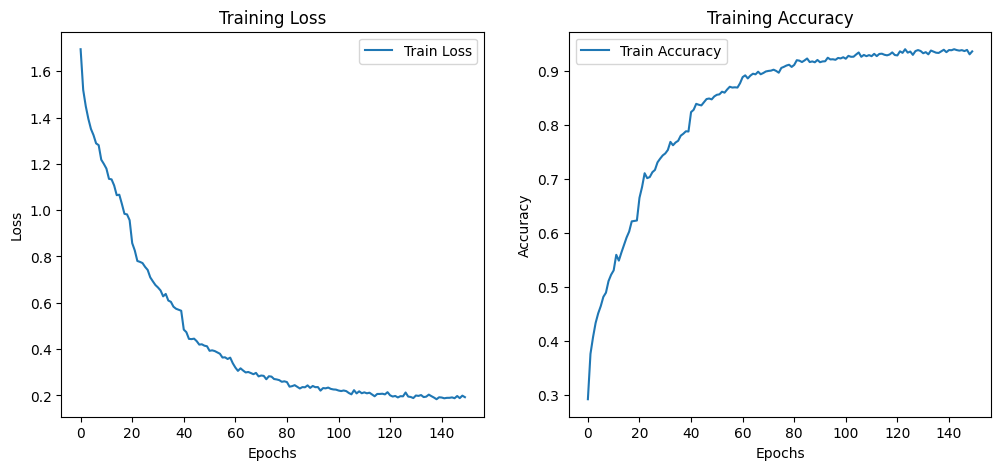

In [20]:
# Create a new model instance with the current parameters
model_MLP_b = MLP().to(device)

model_MLP_b.apply(MLP.init_weights)  # Initialize weights

criterion = nn.CrossEntropyLoss()  # Create loss function instance
optimizer = optim.Adam(model_MLP_b.parameters(), lr=0.001, weight_decay = 1e-4)  # Create optimizer instance
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Learning rate scheduler

# Store the history of loss and accuracy
history = {
    'train_loss': [],
    'train_acc': [],
}

# Training loop
num_epochs = 150  # Number of epochs for training
for epoch in range(num_epochs):
    model_MLP_b.train()  # Set the model to training mode
    running_loss = 0.0  # Accumulator for loss values
    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total predictions

    # Iterate through mini-batches of the training dataset
    for images, labels in train_balanced_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)  # Ensure labels are class indices

        optimizer.zero_grad()  # Reset gradients before backpropagation
        outputs = model_MLP_b(images)  # Forward pass: compute predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update weights using the optimizer

        running_loss += loss.item()  # Accumulate loss for reporting
        _, predicted = torch.max(outputs.data, 1)  # Get class index with highest probability
        total += labels.size(0)  # Update total sample count
        correct += (predicted == labels).sum().item()  # Count correct predictions

    scheduler.step()  # Update learning rate using the scheduler

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_balanced_loader)  # Average loss for the epoch
    epoch_acc = correct / total  # Accuracy for the epoch

    history['train_loss'].append(epoch_loss)  # Store loss in history
    history['train_acc'].append(epoch_acc)  # Store accuracy in history

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Validation (evaluation on the validation dataset)
y_true, y_pred = [], []  # Lists to store true and predicted labels
model_MLP_b.eval()  # Set model to evaluation mode

with torch.no_grad():  # Disable gradient computation for efficiency
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)  # Convert labels to class indices

        outputs = model_MLP_b(images)  # Get model predictions
        predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

        y_true.extend(labels.cpu().numpy())  # Store true labels
        y_pred.extend(predictions.cpu().numpy())  # Store predicted labels


# Plot the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Training and Validation for the Balanced Dataset

In this section, we performed training and validation for the **balanced dataset** using a grid search over different hyperparameter combinations. The goal was to find the best model configuration in terms of performance, particularly based on the **weighted F1 score** on the validation set.

In [22]:
# To save the best model and its parameters
best_weighted_f1_balanced = 0
best_model_balanced = None
best_params_balanced = None
results_balanced = []

print(f"Total combinations to try: {len(all_params)}")

for i, params in enumerate(all_params):
    print(f"\nTraining combination {i+1}/{len(all_params)}")
    print("Parameters:", params)

    # Create DataLoader with the current batch size
    train_balanced_loader = DataLoader(train_dataset_balanced, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create a new model instance with the current parameters
    model_MLP_balanced = MLP(hidden_sizes=params['hidden_sizes'], dropout_p=params['dropout']).to(device)

    model_MLP_balanced.apply(MLP.init_weights)  # Initialize weights

    criterion = nn.CrossEntropyLoss()  # Create loss function instance
    optimizer = optim.Adam(model_MLP_balanced.parameters(), lr=params['learning_rate'], weight_decay = 1e-4)  # Create optimizer instance
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Learning rate scheduler

    # Store the history of loss and accuracy
    history = {
        'train_loss': [],
        'train_acc': [],
    }

    # Training loop
    num_epochs = 130  # Number of epochs for training
    for epoch in range(num_epochs):
        model_MLP_balanced.train()  # Set the model to training mode
        running_loss = 0.0  # Accumulator for loss values
        correct = 0  # Counter for correct predictions
        total = 0  # Counter for total predictions

        # Iterate through mini-batches of the training dataset
        for images, labels in train_balanced_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)  # Ensure labels are class indices

            optimizer.zero_grad()  # Reset gradients before backpropagation
            outputs = model_MLP_balanced(images)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update weights using the optimizer

            running_loss += loss.item()  # Accumulate loss for reporting
            _, predicted = torch.max(outputs.data, 1)  # Get class index with highest probability
            total += labels.size(0)  # Update total sample count
            correct += (predicted == labels).sum().item()  # Count correct predictions

        scheduler.step()  # Update learning rate using the scheduler

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_balanced_loader)  # Average loss for the epoch
        epoch_acc = correct / total  # Accuracy for the epoch

        history['train_loss'].append(epoch_loss)  # Store loss in history
        history['train_acc'].append(epoch_acc)  # Store accuracy in history

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation (evaluation on the validation dataset)
    y_true, y_pred = [], []  # Lists to store true and predicted labels
    model_MLP_balanced.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)  # Convert labels to class indices

            outputs = model_MLP_balanced(images)  # Get model predictions
            predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

            y_true.extend(labels.cpu().numpy())  # Store true labels
            y_pred.extend(predictions.cpu().numpy())  # Store predicted labels

    conf_matrix = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    class_report = classification_report(y_true, y_pred, target_names=class_labels.values())  # Generate classification report
    class_report_dict = classification_report(y_true, y_pred, target_names=class_labels.values(), output_dict=True)
    f1_weighted_avg = class_report_dict['weighted avg']['f1-score']  # Extract weighted F1 score
    print(f"Validation Weighted AVG F1 Score for the Balanced Dataset: {f1_weighted_avg:.2%}")

    # Save results
    results_balanced.append({
        'params': params,
        'f1_weighted_avg': f1_weighted_avg,
        'train_loss': history['train_loss'],
        'train_acc': history['train_acc'],
    })

    # Check if this model is the best one so far
    if f1_weighted_avg > best_weighted_f1_balanced:
        best_weighted_f1_balanced = f1_weighted_avg # Update best F1 score
        best_model_balanced = model_MLP_balanced  # Save the best model
        best_params_balanced = params  # Save the best parameters
        print("New best model found!")

        # Save the best model
        torch.save({
            'model_state_dict': best_model_balanced.state_dict(),
            'params': best_params_balanced,
            'f1_weighted_avg': best_weighted_f1_balanced,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'train_loss': history['train_loss'],
            'train_acc': history['train_acc'],
        }, 'balanced_best_mlp_model_params.pth')


# Print the best model and its parameters
print("\nBest Model Parameters for the Balanced Dataset:")
print(f"Parameters: {best_params_balanced}")
print(f"Best Validation F1 Score: {best_weighted_f1_balanced:.2%}")

# Save all results to a CSV file
results_df_balanced = pd.DataFrame(results_balanced)
results_df_balanced.to_csv('balanced_mlp_grid_search_results.csv', index=False)

Total combinations to try: 90

Training combination 1/90
Parameters: {'hidden_sizes': [512, 256, 128], 'learning_rate': 0.001, 'batch_size': 64, 'dropout': 0.05}
Epoch 1, Loss: 1.6807, Accuracy: 0.3040
Epoch 2, Loss: 1.4949, Accuracy: 0.3884
Epoch 3, Loss: 1.4204, Accuracy: 0.4314
Epoch 4, Loss: 1.3536, Accuracy: 0.4564
Epoch 5, Loss: 1.3109, Accuracy: 0.4694
Epoch 6, Loss: 1.2823, Accuracy: 0.4840
Epoch 7, Loss: 1.2367, Accuracy: 0.5039
Epoch 8, Loss: 1.2009, Accuracy: 0.5256
Epoch 9, Loss: 1.1712, Accuracy: 0.5323
Epoch 10, Loss: 1.1248, Accuracy: 0.5569
Epoch 11, Loss: 1.1031, Accuracy: 0.5660
Epoch 12, Loss: 1.0815, Accuracy: 0.5737
Epoch 13, Loss: 1.0370, Accuracy: 0.5966
Epoch 14, Loss: 0.9943, Accuracy: 0.6137
Epoch 15, Loss: 0.9845, Accuracy: 0.6160
Epoch 16, Loss: 0.9452, Accuracy: 0.6326
Epoch 17, Loss: 0.9099, Accuracy: 0.6520
Epoch 18, Loss: 0.8749, Accuracy: 0.6596
Epoch 19, Loss: 0.8568, Accuracy: 0.6666
Epoch 20, Loss: 0.8278, Accuracy: 0.6844
Epoch 21, Loss: 0.7174, Acc

### Model Evaluation and Hyperparameter Optimization for the Balanced Dataset

In this section, the goal was to evaluate the best model trained for the balanced dataset and optimize the **loss function** and **optimizer** to potentially further improve the model's performance.

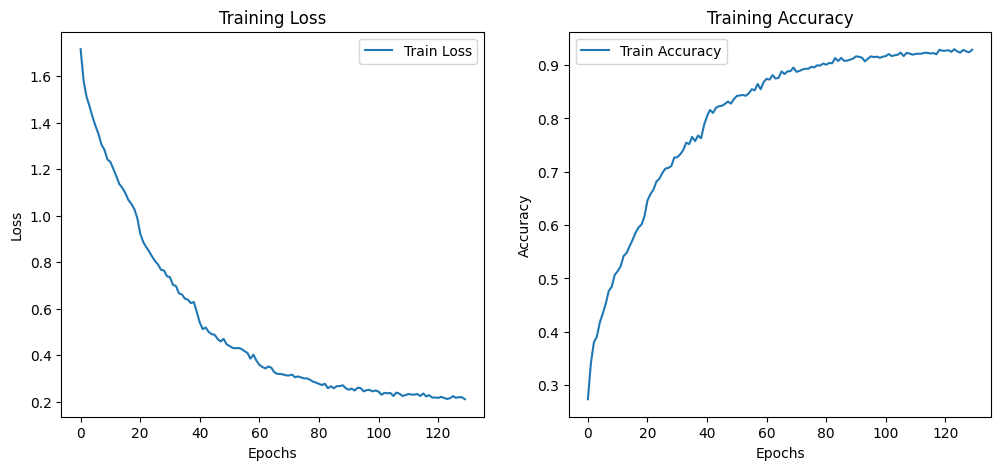


Training combination 1/4
Parameters: {'loss_function': <class 'torch.nn.modules.loss.CrossEntropyLoss'>, 'optimizer': <class 'torch.optim.adam.Adam'>}
Epoch 1, Loss: 1.7128, Accuracy: 0.2889
Epoch 2, Loss: 1.5776, Accuracy: 0.3514
Epoch 3, Loss: 1.4971, Accuracy: 0.3836
Epoch 4, Loss: 1.4488, Accuracy: 0.4079
Epoch 5, Loss: 1.4084, Accuracy: 0.4274
Epoch 6, Loss: 1.3611, Accuracy: 0.4554
Epoch 7, Loss: 1.3437, Accuracy: 0.4654
Epoch 8, Loss: 1.2982, Accuracy: 0.4839
Epoch 9, Loss: 1.2783, Accuracy: 0.4850
Epoch 10, Loss: 1.2452, Accuracy: 0.5027
Epoch 11, Loss: 1.1939, Accuracy: 0.5277
Epoch 12, Loss: 1.1683, Accuracy: 0.5377
Epoch 13, Loss: 1.1359, Accuracy: 0.5566
Epoch 14, Loss: 1.1319, Accuracy: 0.5549
Epoch 15, Loss: 1.0987, Accuracy: 0.5756
Epoch 16, Loss: 1.0788, Accuracy: 0.5759
Epoch 17, Loss: 1.0592, Accuracy: 0.5919
Epoch 18, Loss: 1.0417, Accuracy: 0.6060
Epoch 19, Loss: 1.0181, Accuracy: 0.6111
Epoch 20, Loss: 1.0082, Accuracy: 0.6050
Epoch 21, Loss: 0.9585, Accuracy: 0.6

In [26]:
# Load the best model trained for the balanced dataset
checkpoint = torch.load('balanced_best_mlp_model_params.pth', weights_only=False)
best_hidden_sizes_balanced = checkpoint['params']['hidden_sizes']
best_learning_rate_balanced = checkpoint['params']['learning_rate']
best_batch_size_balanced = checkpoint['params']['batch_size']
best_dropout_balanced = checkpoint['params']['dropout']
best_weighted_f1_balanced = checkpoint['f1_weighted_avg']
best_params_balanced = checkpoint['params']
best_model_balanced = checkpoint['model_state_dict']

# Plot the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(checkpoint['train_loss'], label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(checkpoint['train_acc'], label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the best_l_and_o with the static loss function and optimizer that were used to be trained
best_l_and_o_balanced = {
    'loss_function': nn.CrossEntropyLoss,
    'optimizer': optim.Adam,
}
results_l_o_balanced = []  # List to store results for different loss functions and optimizers

# Create DataLoader with the best batch size
train_balanced_loader = DataLoader(train_dataset_balanced, batch_size=best_batch_size_balanced, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size_balanced, shuffle=False)

for i, l_o in enumerate(all_loss_and_opt):
    print(f"\nTraining combination {i+1}/{len(all_loss_and_opt)}")
    print("Parameters:", l_o)

    # Create a new model instance with the current parameters
    best_MLP = MLP(hidden_sizes=best_hidden_sizes_balanced, dropout_p=best_dropout_balanced).to(device)
    best_MLP.apply(MLP.init_weights)  # Initialize weights

    criterion = l_o['loss_function']()  # Create loss function instance
    optimizer = l_o['optimizer'](best_MLP.parameters(), lr=best_learning_rate_balanced, weight_decay = 1e-4)  # Create optimizer instance
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate scheduler

    # Store the history of loss and accuracy
    history = {
        'train_loss': [],
        'train_acc': [],
    }

    # Training loop
    for epoch in range(130):
        best_MLP.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_balanced_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = best_MLP(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        epoch_loss = running_loss / len(train_balanced_loader)
        epoch_acc = correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation (evaluation on the validation dataset)
    y_val_true, y_val_pred = [], []  # Lists to store true and predicted labels
    best_MLP.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = best_MLP(images)  # Get model predictions
            predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability

            y_val_true.extend(labels.cpu().numpy())  # Store true labels
            y_val_pred.extend(predictions.cpu().numpy())

    conf_matrix = confusion_matrix(y_val_true, y_val_pred)  # Compute confusion matrix
    class_report = classification_report(y_val_true, y_val_pred, target_names=class_labels.values())  # Generate classification report
    class_report_dict = classification_report(y_val_true, y_val_pred, target_names=class_labels.values(), output_dict=True)
    f1_weighted_avg = class_report_dict['weighted avg']['f1-score']  # Extract weighted F1 score
    print(f"Validation Weighted AVG F1 Score: {f1_weighted_avg:.2%}")

    # Save results
    results_l_o_balanced.append({
        'params': l_o,
        'f1_weighted_avg': f1_weighted_avg,
        'train_loss': history['train_loss'],
        'train_acc': history['train_acc'],
    })

    flag = False
    if f1_weighted_avg > best_weighted_f1_balanced:
        flag = True
        best_weighted_f1_balanced = f1_weighted_avg
        best_model = best_MLP
        best_l_and_o_balanced = l_o  # Save the best loss function and optimizer
        print("New best model found!")

        # Save the best model
        torch.save({
            'model_state_dict': best_MLP.state_dict(),
            'params': best_params_balanced,
            'loss_and_opt': best_l_and_o_balanced,
            'f1_weighted_avg': best_weighted_f1_balanced,
            'confusion_matrix': conf_matrix,
            'classification_report': class_report,
            'train_loss': history['train_loss'],
            'train_acc': history['train_acc'],
        }, 'balanced_best_mlp_model_l_o.pth')

    if not flag and i == len(all_loss_and_opt) - 1:  # Check if this is the last iteration
        print("No better model found with different loss function and optimizer.")

        torch.save({
            'model_state_dict': best_model_balanced,
            'params': best_params_balanced,
            'loss_and_opt': best_l_and_o_balanced,
            'f1_weighted_avg': best_weighted_f1_balanced,
            'confusion_matrix': checkpoint['confusion_matrix'],
            'classification_report': checkpoint['classification_report'],
            'train_loss': checkpoint['train_loss'],
            'train_acc': checkpoint['train_acc'],
        }, 'balanced_best_mlp_model_l_o.pth')

# Print the best model and its parameters
print("\nBest Model Parameters:")
print(f"Loss and Opt: {best_l_and_o_balanced}")
print(f"Best Validation Weighted AVG F1 Score: {best_weighted_f1_balanced:.2%}")

results_df_l_o_balanced = pd.DataFrame(results_l_o_balanced)
results_df_l_o_balanced.to_csv('balanced_mlp_l_and_o_results.csv', index=False)

### Model Evaluation on Test Dataset for the Balanced Dataset

This section involves evaluating the best model on the **test dataset** using metrics such as **confusion matrix**, **classification report**, and **F1 score**.

Validation Confusion Matrix for the Balanced Dataset:



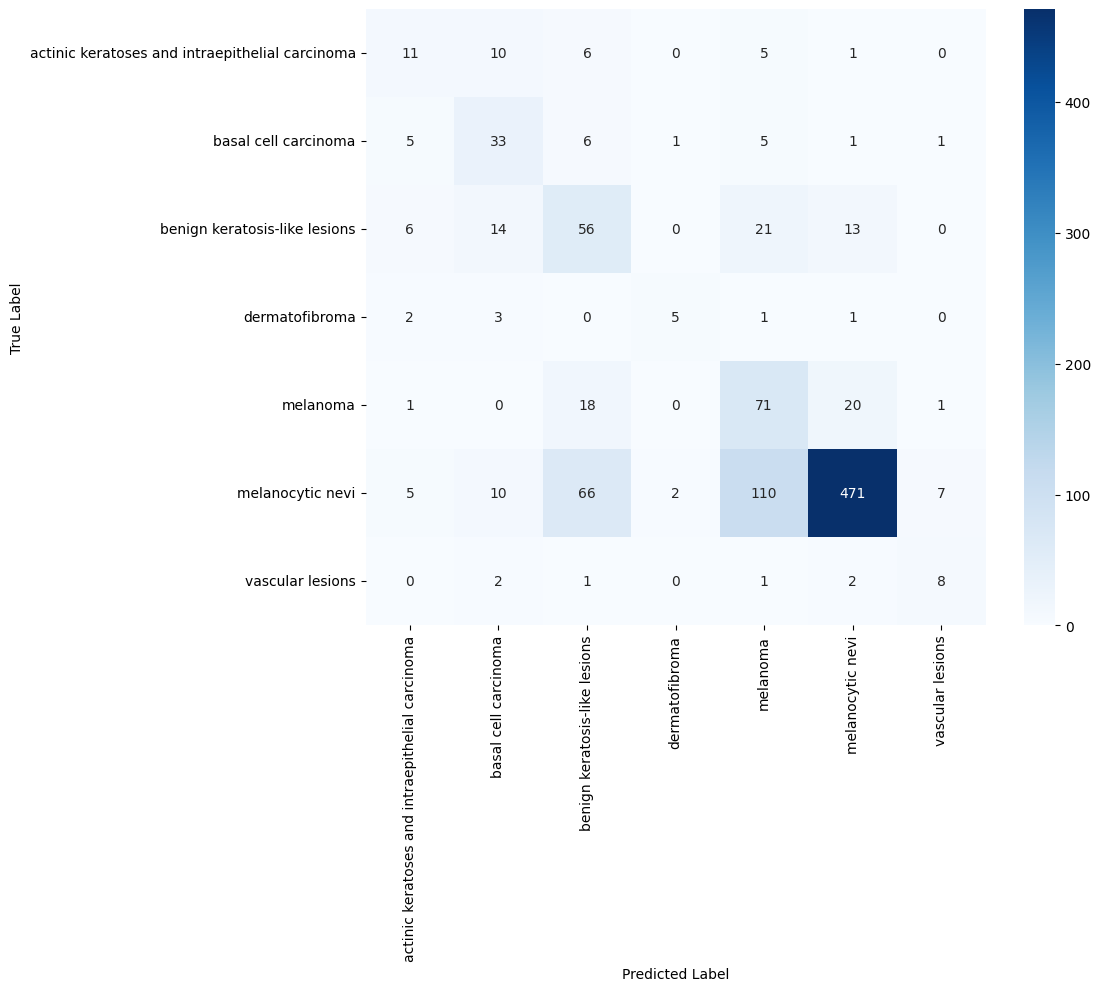


Validation Classification Report for the Balanced Dataset:
                                                  precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.37      0.33      0.35        33
                           basal cell carcinoma       0.46      0.63      0.53        52
                  benign keratosis-like lesions       0.37      0.51      0.43       110
                                 dermatofibroma       0.62      0.42      0.50        12
                                       melanoma       0.33      0.64      0.44       111
                               melanocytic nevi       0.93      0.70      0.80       671
                               vascular lesions       0.47      0.57      0.52        14

                                       accuracy                           0.65      1003
                                      macro avg       0.51      0.54      0.51      1003
                                   weighted avg

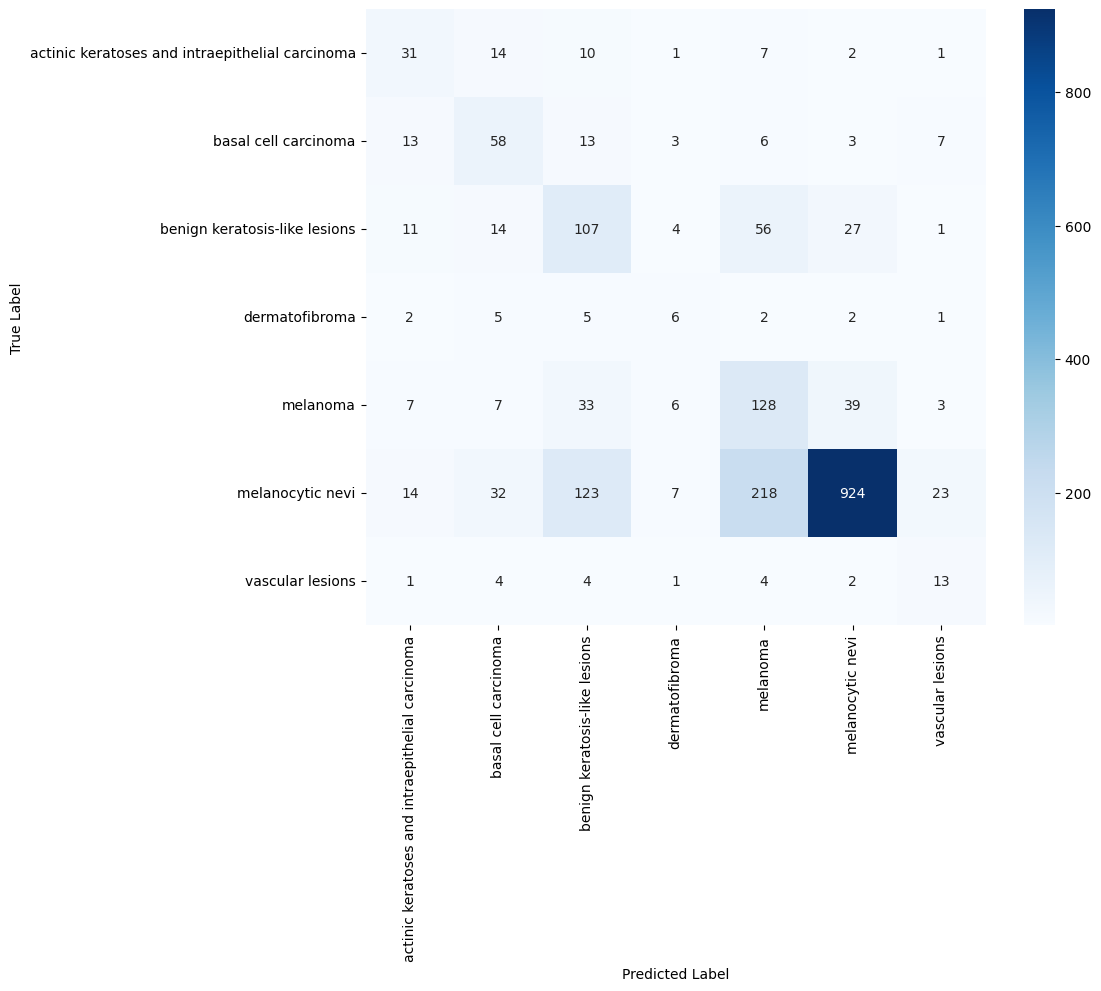


Test Classification Report for the Balanced Dataset:
                                                  precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.39      0.47      0.43        66
                           basal cell carcinoma       0.43      0.56      0.49       103
                  benign keratosis-like lesions       0.36      0.49      0.42       220
                                 dermatofibroma       0.21      0.26      0.24        23
                                       melanoma       0.30      0.57      0.40       223
                               melanocytic nevi       0.92      0.69      0.79      1341
                               vascular lesions       0.27      0.45      0.33        29

                                       accuracy                           0.63      2005
                                      macro avg       0.41      0.50      0.44      2005
                                   weighted avg      

In [27]:
# Load the best model
checkpoint = torch.load('balanced_best_mlp_model_l_o.pth', weights_only=False)
conf_matrix = checkpoint['confusion_matrix']
class_report = checkpoint['classification_report']

print("Validation Confusion Matrix for the Balanced Dataset:\n")
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nValidation Classification Report for the Balanced Dataset:\n", class_report)

best_model_MLP = MLP(hidden_sizes=checkpoint['params']['hidden_sizes'], 
                dropout_p=checkpoint['params']['dropout']).to(device)
best_model_MLP.load_state_dict(checkpoint['model_state_dict'])
best_model_MLP.eval()  # Set to evaluation mode


# Testing (evaluation on the test dataset)
y_test_pred = []  # List to store predicted labels
y_test_true = []  # List to store true labels

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # Move images to device
        labels = labels.squeeze().long().to(device)  # Convert labels to class indices
        
        outputs = best_model_MLP(images)  # Get model predictions
        predictions = torch.argmax(outputs, dim=1)  # Select class with highest probability
        
        y_test_true.extend(labels.cpu().numpy())  # Store true labels
        y_test_pred.extend(predictions.cpu().numpy())  # Store predicted labels

conf_matrix_test = confusion_matrix(y_test_true, y_test_pred)  # Compute confusion matrix
class_report_test = classification_report(y_test_true, y_test_pred, target_names=class_labels.values())  # Generate classification report
class_report_dict_test = classification_report(y_test_true, y_test_pred, target_names=class_labels.values(), output_dict=True)
f1_weighted_avg_test = class_report_dict_test['weighted avg']['f1-score']  # Extract weighted F1 score
print(f"Test Weighted AVG F1 Score for the Balanced Dataset: {f1_weighted_avg_test:.2%}")

print("Test Confusion Matrix for the Balanced Dataset:\n")  # Print confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nTest Classification Report for the Balanced Dataset:\n", class_report_test)  # Print classification report